In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
from time import time

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from src.io.cache_io import temp_dir
from src.loggers import set_console_handler_level
from src.models.speclet_nine import SpecletNine
from src.plot.plotnine_helpers import set_gg_theme

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARNING)

set_gg_theme()
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
# HDI_PROB = read_project_configuration().modeling.highest_density_interval

In [5]:
sp9 = SpecletNine("test-model", root_cache_dir=temp_dir())

In [6]:
data = sp9.data_manager.get_data()
ct_i = np.abs(np.random.normal(loc=100, scale=5, size=data.shape[0])) + 1
# ct_i = np.ones(data.shape[0])
ct_f = np.abs(ct_i + np.random.normal(loc=0, scale=10, size=data.shape[0]))
data["counts_initial_adj"] = ct_i.astype(np.int64)
data["counts_final"] = ct_f.astype(np.int64)
sp9.data_manager.set_data(data, apply_transformations=False)

[11/05/21 08:23:25] WARNING  Dropping 0 sgRNA that map to multiple genes.     ]8;id=588810;file:///Users/admin/Lab_Projects/speclet/src/data_processing/achilles.py\achilles.py]8;;\:616

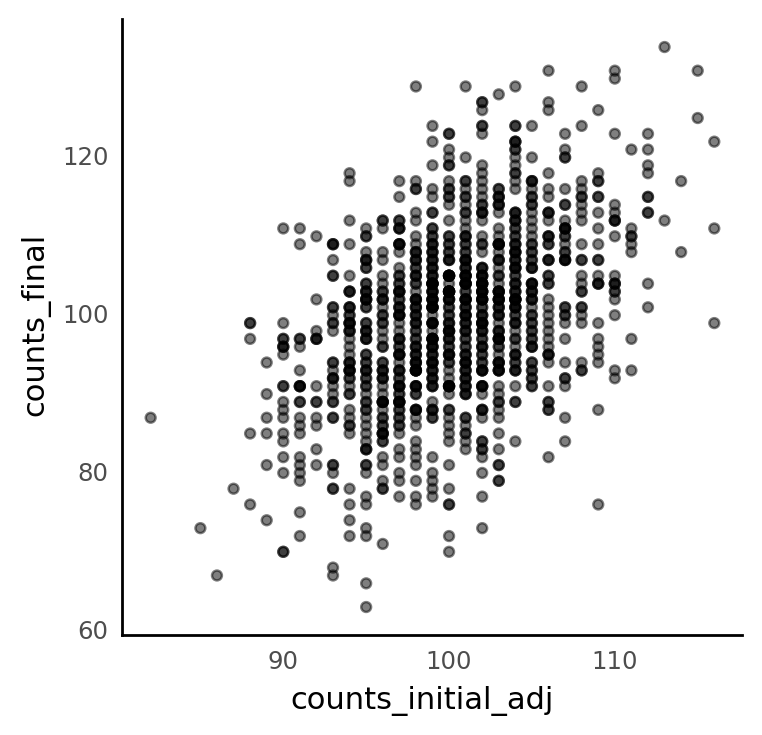

<ggplot: (346250162)>

In [7]:
(
    gg.ggplot(data, gg.aes(x="counts_initial_adj", y="counts_final"))
    + gg.geom_point(alpha=0.5)
)

In [8]:
sp9.build_model()

In [9]:
assert sp9.model is not None
with sp9.model:
    sp9_prior_pred = pm.sample_prior_predictive(random_seed=1234)

In [10]:
def plot_prior_pred(prior_samples: np.ndarray, scales: str = "fixed") -> gg.ggplot:
    """Plot prior predictive samples

    Args:
        prior_samples ([type]): Prior samples array with shape [samples, draws].

    Returns:
        gg.ggplot: A nice lil' plot for you and your buds.
    """
    prior_pred_df = (
        pd.DataFrame(prior_samples.T)
        .pivot_longer(names_to="prior_pred_sample", values_to="draw")
        .astype({"prior_pred_sample": "str"})
    )
    return (
        gg.ggplot(prior_pred_df, gg.aes(x="draw", fill="prior_pred_sample"))
        + gg.facet_wrap("prior_pred_sample", scales=scales)
        + gg.geom_histogram(bins=50, alpha=0.5, position="identity")
        + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(figure_size=(8, 6), legend_position="none")
    )

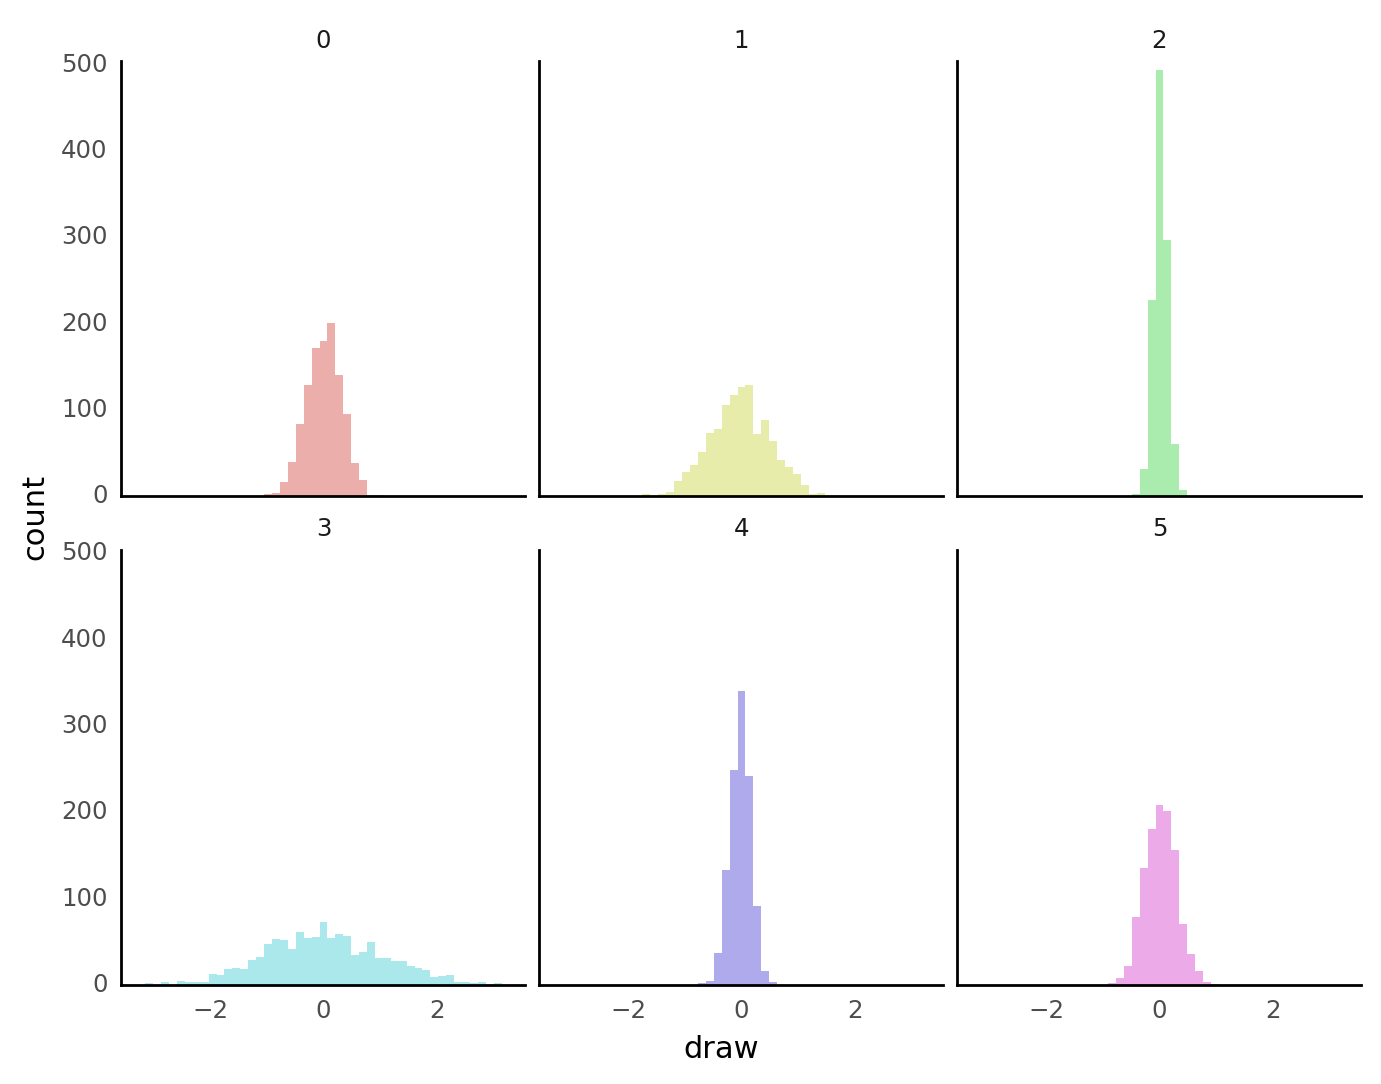

<ggplot: (353513698)>

In [11]:
plot_prior_pred(sp9_prior_pred["beta"][:6, :, :].reshape(6, -1))

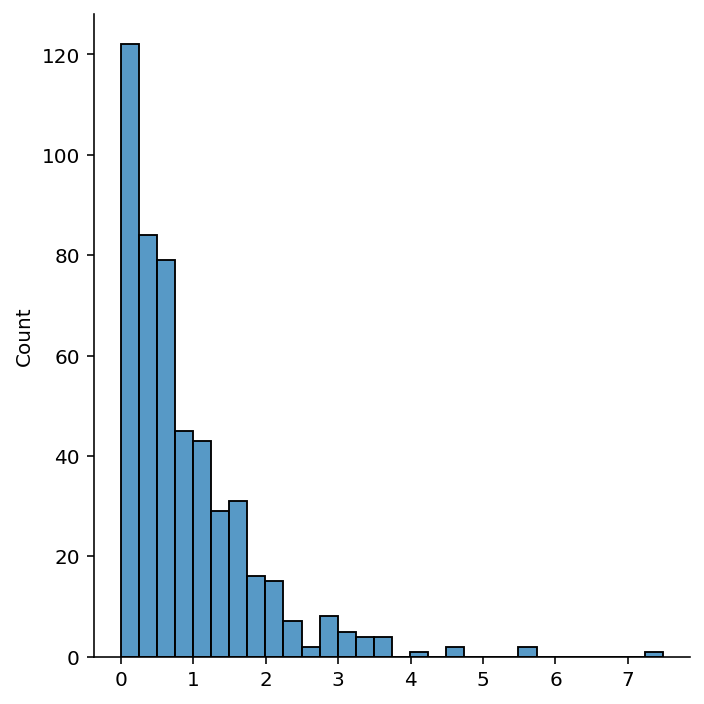

In [12]:
sns.displot(sp9_prior_pred["alpha"], kind="hist")
plt.show()

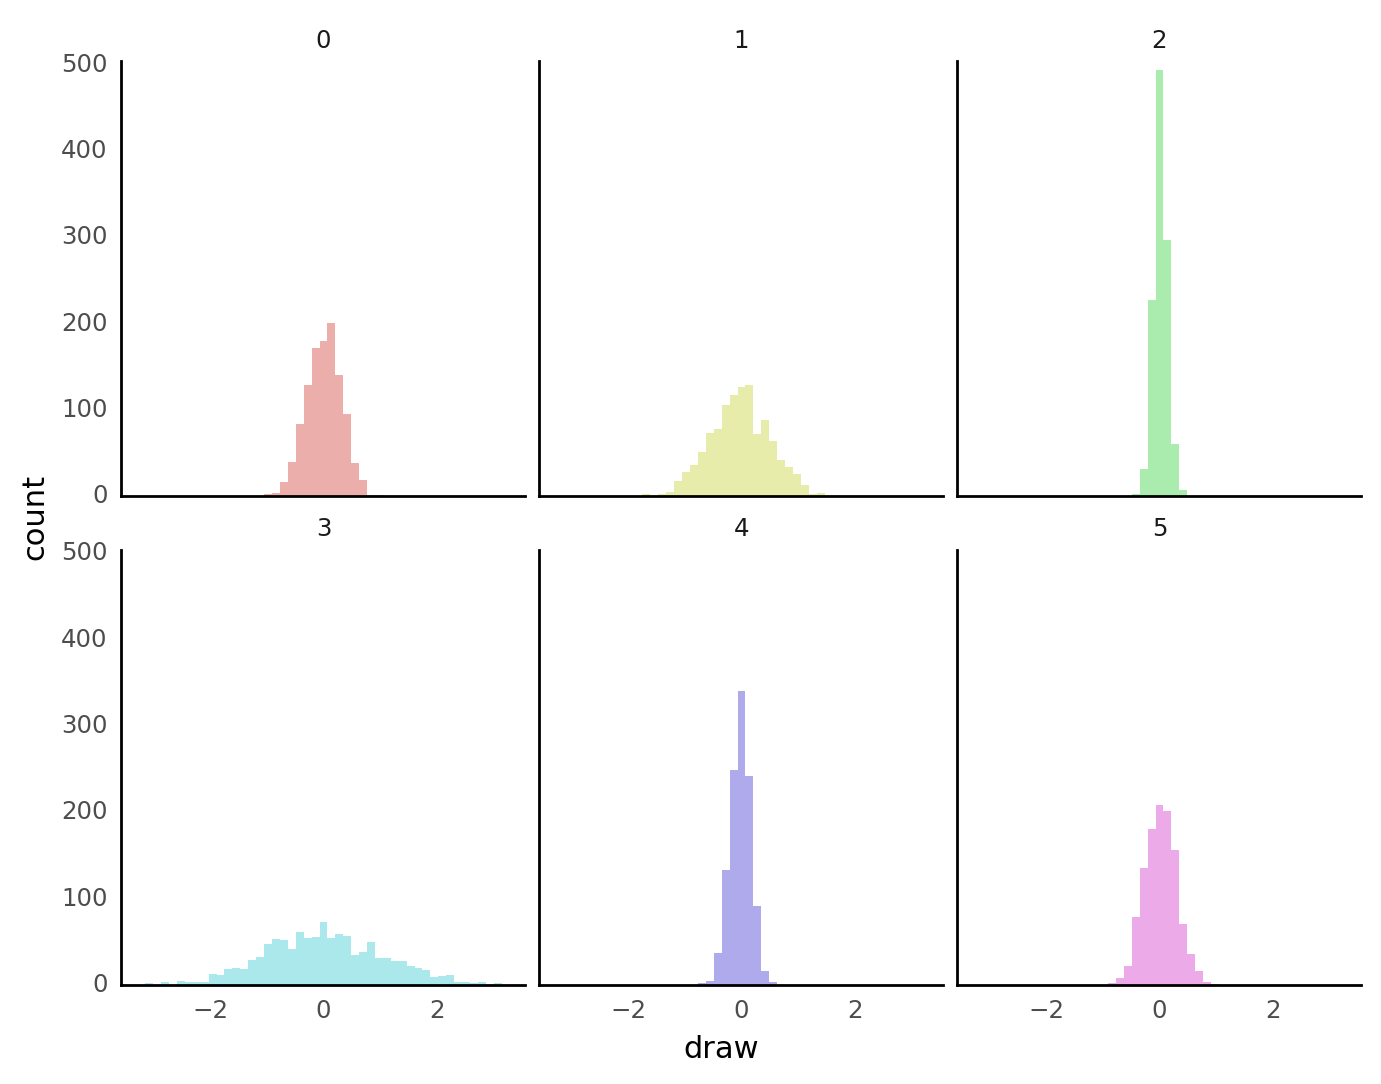

<ggplot: (353749526)>

In [13]:
plot_prior_pred(sp9_prior_pred["eta"][:6, :])

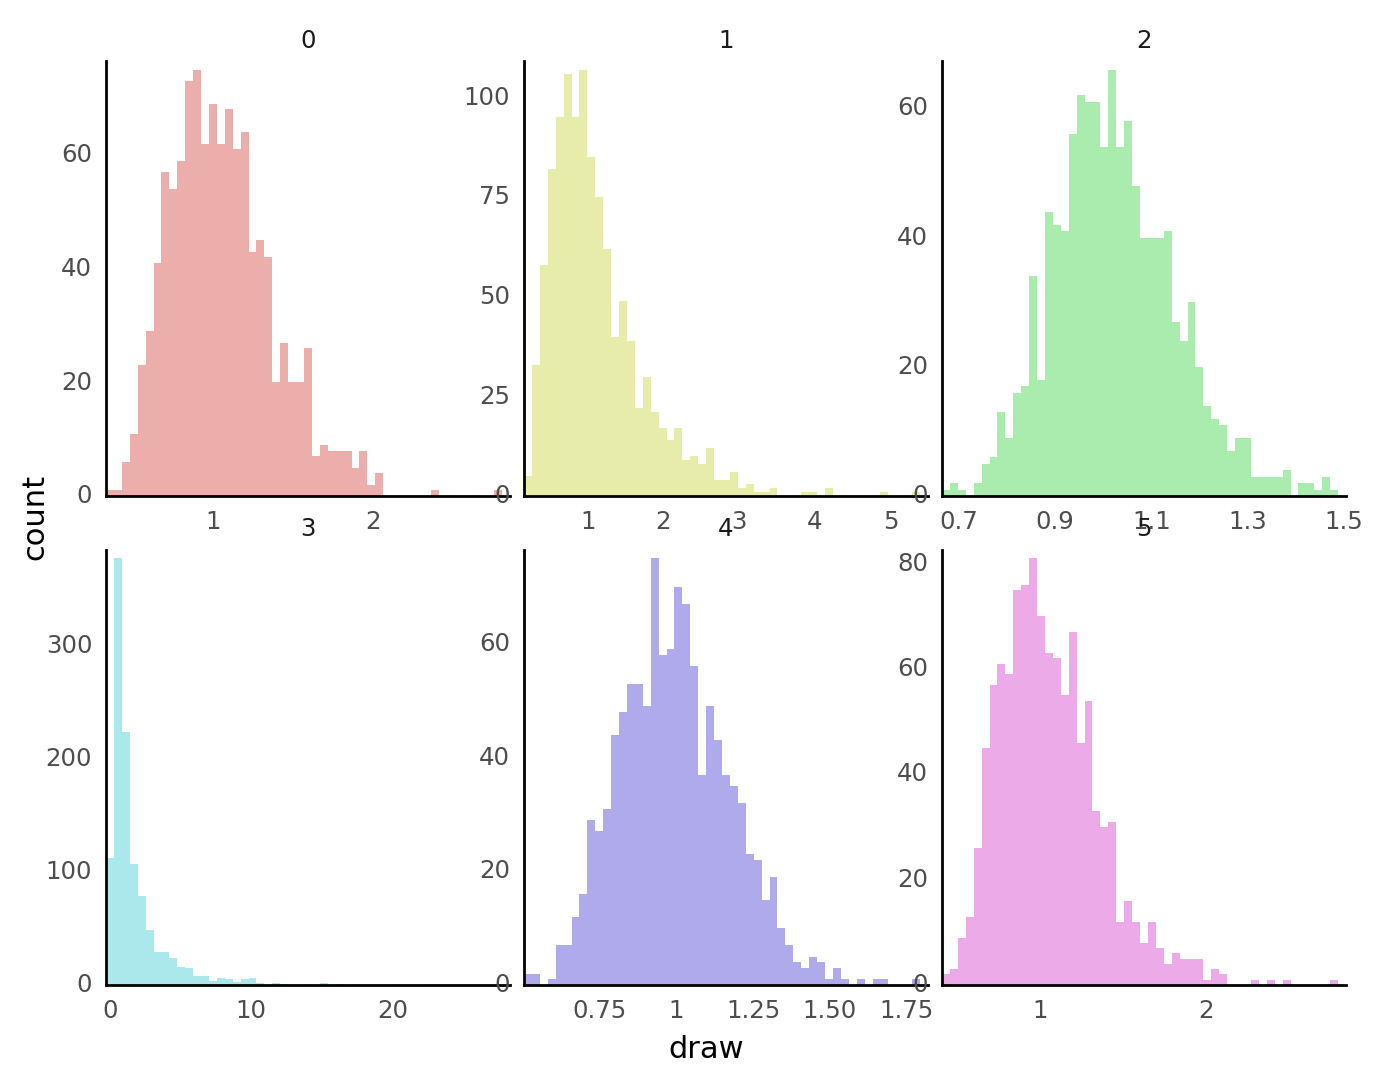

<ggplot: (353743379)>

In [14]:
plot_prior_pred(sp9_prior_pred["mu"][:6, :], scales="free")

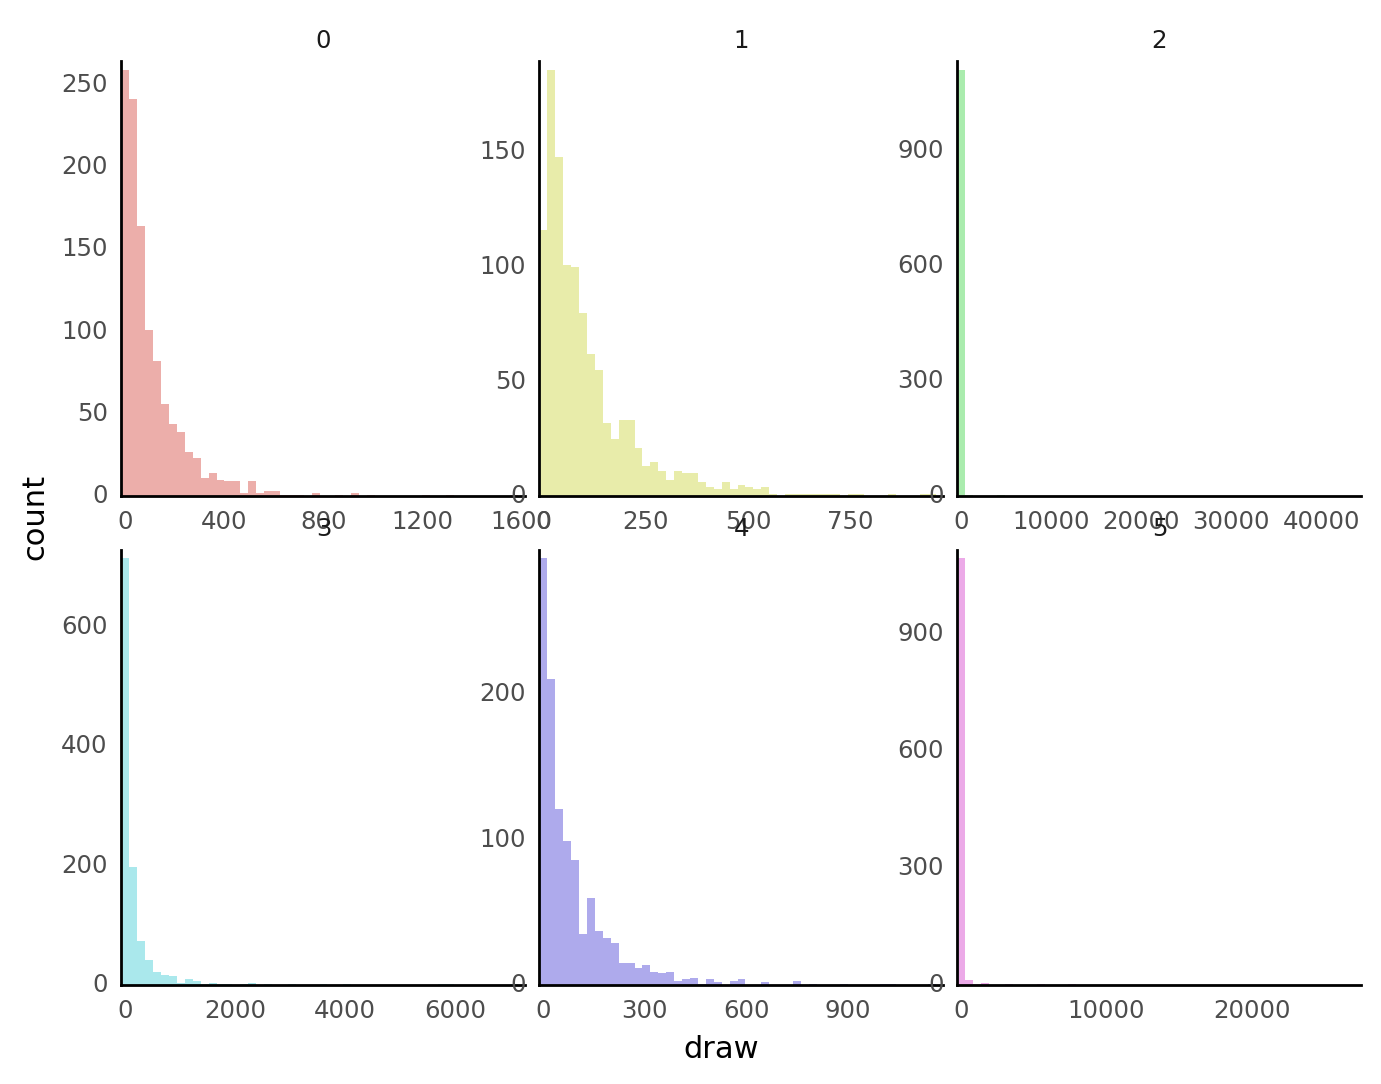

<ggplot: (354132146)>

In [15]:
(plot_prior_pred(sp9_prior_pred["y"][:6, :], scales="free"))

In [16]:
sp9_prior_pred["alpha"][:6]

array([0.6907363 , 1.04467459, 0.00184826, 0.42503755, 0.54317984,
       0.01076485])

In [17]:
sp9_prior_pred["mu"].mean(axis=1)[:6]

array([1.05694165, 1.12386565, 1.02394244, 1.81139972, 0.99649316,
       1.06040632])

---

In [18]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.33 minutes


In [19]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-11-05

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: sp9

pandas    : 1.3.2
janitor   : 0.21.0
pymc3     : 3.11.2
matplotlib: 3.4.3
plotnine  : 0.8.0
sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
logging   : 0.5.1.2
seaborn   : 0.11.2
numpy     : 1.21.2
arviz     : 0.11.2

